# Phase 2 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

## Ingestion & Prepare Final Dataset
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

### Basics

In [64]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn as sns

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [65]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False
    
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"
    
    all_files = os.listdir(directory) # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + directory + i)
        
        output[i] = pd.read_csv(directory + i , dtype="str", skiprows =1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = np.array([is_integer(x) for x in output[i]['id']]) # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
        output[i] = output[i][invalid_rows] # remove invalid rows
    
    return output # return dictionary of dataframe

In [66]:
# Define the output path for the pickle
pickle_file = "clean_data.pickle" # path to save cleaned data

# Identify the columns we'll be keeping from the dataset
# list of features to use for this study as indicated in the handout
cols_to_pick = ["id","loan_amnt", "funded_amnt", "term", "int_rate", "installment", "grade", 
                "emp_length","home_ownership", "annual_inc", "verification_status", "issue_d", "loan_status","purpose", 
                "dti", "delinq_2yrs", "earliest_cr_line", "open_acc", "pub_rec","last_fico_range_high", 
                "last_fico_range_low", "revol_bal", "revol_util", "total_pymnt","last_pymnt_d", "recoveries"] 

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ["loan_amnt","funded_amnt","installment","annual_inc","dti","delinq_2yrs","open_acc",
              "last_fico_range_high", "last_fico_range_low", "total_pymnt","recoveries","revol_bal","pub_rec"]
cat_cols = ["term","grade","emp_length","home_ownership","verification_status","loan_status","purpose"] # categorical features
perc_cols = ["int_rate", "revol_util"]
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d"]

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.

# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))
continuous_features = list(float_cols + perc_cols)

# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files("./data") # dictioary of (filename, dataframe) as (key, value)

# Combine the files
data_cs = pd.concat(files_cs, axis=0, ignore_index=True) # combine "files_cs" into a pandas dataframe
              # resent index with drop = True

# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]

print("\nStarting with " + str(len(final_data)) + " rows")

Directory ./data/ has 12 files:
    Reading file ./data/LoanStats_securev1_2016Q3.csv.zip
Found 99120 invalid rows which were removed
    Reading file ./data/LoanStats_securev1_2016Q2.csv.zip
Found 97854 invalid rows which were removed
    Reading file ./data/LoanStats3a_securev1.csv.zip
Found 42535 invalid rows which were removed
    Reading file ./data/LoanStats_securev1_2017Q1.csv.zip
Found 96779 invalid rows which were removed
    Reading file ./data/LoanStats3d_securev1.csv.zip
Found 421095 invalid rows which were removed
    Reading file ./data/LoanStats_securev1_2017Q3.csv.zip
Found 122701 invalid rows which were removed
    Reading file ./data/LoanStats_securev1_2017Q2.csv.zip
Found 105451 invalid rows which were removed
    Reading file ./data/LoanStats_securev1_2016Q1.csv.zip
Found 133887 invalid rows which were removed
    Reading file ./data/LoanStats_securev1_2016Q4.csv.zip
Found 103546 invalid rows which were removed
    Reading file ./data/LoanStats3c_securev1.csv.zip
Fo

### Typecast the columns

In [6]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime(x, "%b-%Y").date()

for i in float_cols:
    final_data[i] = final_data[i].astype('float') # typecast float columns

for i in perc_cols:
    final_data[i] = final_data[i].map(lambda x: clean_perc(x)) # apply clean_perc to percentage columns

for i in date_cols:
    final_data[i] = final_data[i].map(lambda x: clean_date(x)) # typecast date cloumns to datatime using clean_date
    
for i in cat_cols:
    final_data[i].loc[pd.isnull(final_data[i])] = None # for categorical features if the value is null/empty set it to None

### Calculate returns for each loan

In [7]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * ((1 - np.power(1 + i, final_data['loan_length'])) / (1 - (1 + i)) ) # compute the quantity given in [] in eq.2.3 of handout
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = ( cash_by_end_of_loan *  np.power(1 + i, remaining_months) )-  final_data["funded_amnt"]

    # Find the percentage return
    ret_val = (12/T) * final_return / final_data["funded_amnt"]
    return ret_val

In [8]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

final_data = final_data.loc[final_data['loan_length'] != 0] # select rows where loan_length is not 0. 
print("Removed " + str(n_rows - len(final_data)) + " rows")



# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

## M1-Pessimistic Method
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)
final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

final_data['ret_PESS'] = 12 * (final_data["total_pymnt"] - final_data["recoveries"] - 
                               final_data["funded_amnt"] ) / final_data["funded_amnt"] / final_data['term_num']

## M2-Optimistic Method
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return
final_data['ret_OPT'] = 12 * (final_data["total_pymnt"] - final_data["recoveries"] - 
                              final_data["funded_amnt"] ) / final_data["funded_amnt"] / final_data['loan_length']

final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = 12 * (final_data["total_pymnt"] - 
                                                         final_data["recoveries"] - 
                                                         final_data["funded_amnt"] ) / final_data["funded_amnt"] / final_data['term_num']

## M3
final_data['ret_INTa'] = ret_method_3(60, 0.002) # call ret_method_3 with T=60, i=0.002
final_data['ret_INTb'] = ret_method_3(60, 0.005) # call ret_method_3 with T=60, i=0.005

fcopy = final_data.copy()
final_data = fcopy.copy()

Removed 6218 rows


## EDA

### Visualize initial variables

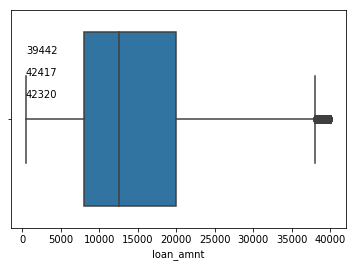

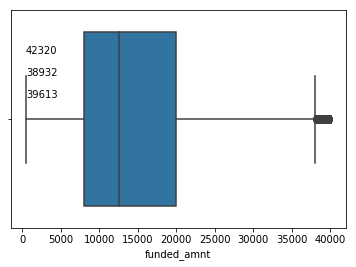

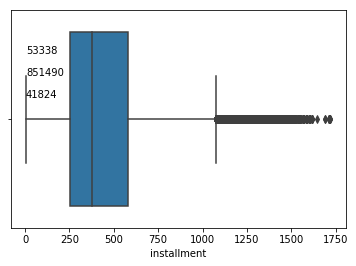

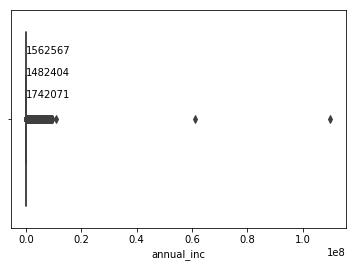

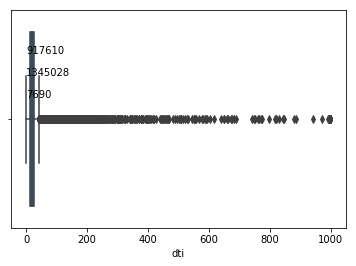

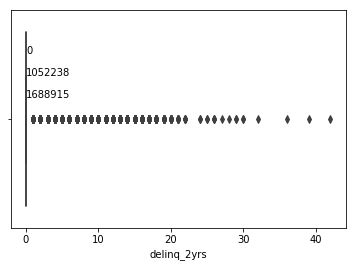

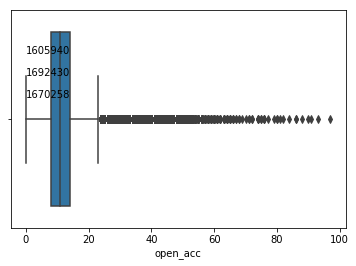

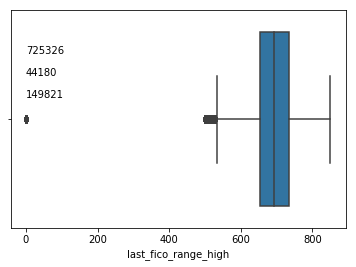

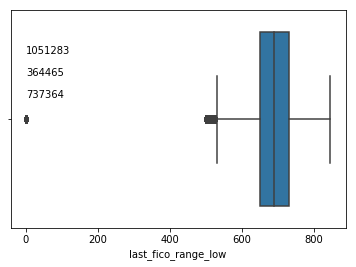

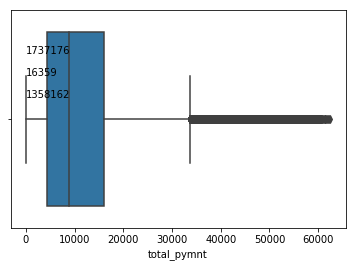

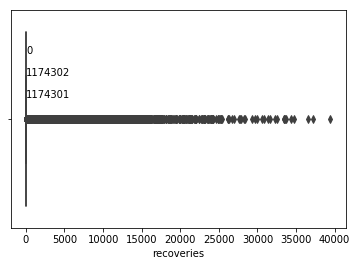

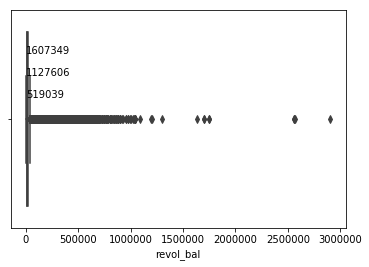

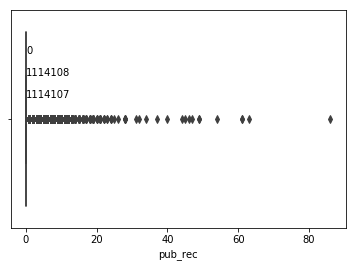

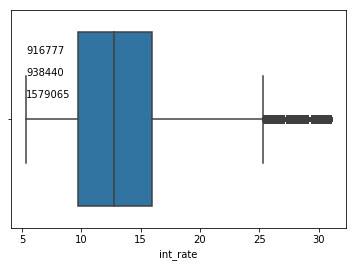

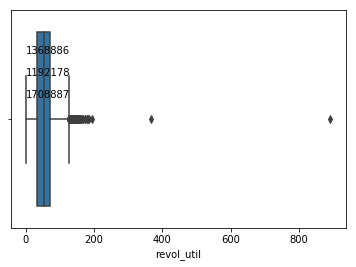

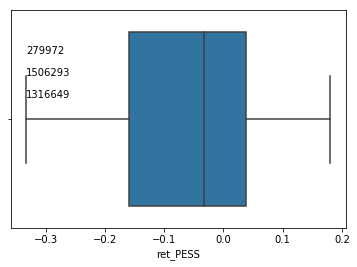

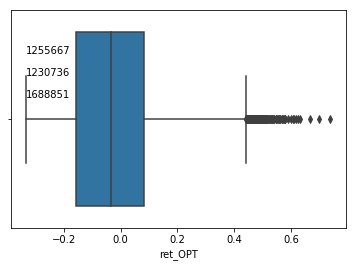

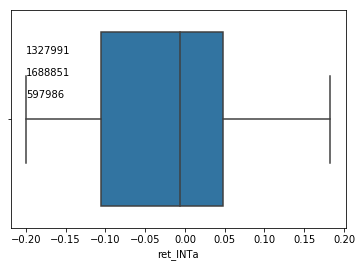

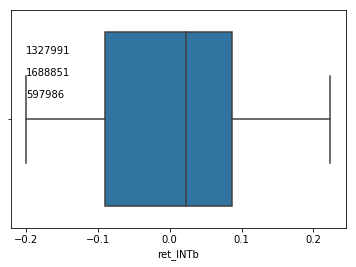

term
2
[[' 36 months' '1260610']
 [' 60 months' '498598']]


grade
7
[['A' '296996']
 ['B' '520527']
 ['C' '521315']
 ['D' '254390']
 ['E' '116174']
 ['F' '38424']
 ['G' '11382']]


emp_length
12
[['1 year' '114808']
 ['10+ years' '585453']
 ['2 years' '158386']
 ['3 years' '139611']
 ['4 years' '105001']
 ['5 years' '108455']
 ['6 years' '80425']
 ['7 years' '74482']
 ['8 years' '75648']
 ['9 years' '66527']
 ['< 1 year' '145876']]


home_ownership
6
[['ANY' '504']
 ['MORTGAGE' '869367']
 ['NONE' '54']
 ['OTHER' '182']
 ['OWN' '191886']
 ['RENT' '697215']]


verification_status
3
[['Not Verified' '561817']
 ['Source Verified' '668294']
 ['Verified' '529097']]


loan_status
9
[['Charged Off' '191939']
 ['Current' '792304']
 ['Default' '392']
 ['Does not meet the credit policy. Status:Charged Off' '761']
 ['Does not meet the credit policy. Status:Fully Paid' '1988']
 ['Fully Paid' '736866']
 ['In Grace Period' '8753']
 ['Late (16-30 days)' '5758']
 ['Late (31-120 days)' '20447']]


purp

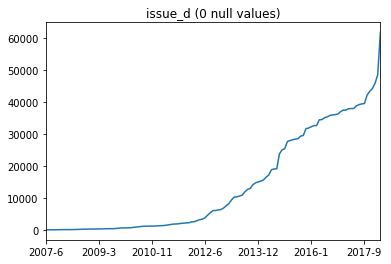

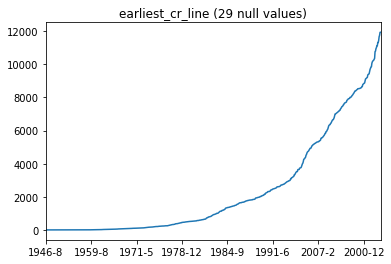

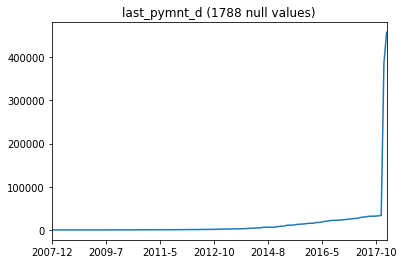

In [9]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    # Float columns
    for i in float_cols + perc_cols + ret_cols:
        sns.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = np.argsort(final_data[i]) # get 3 highest values
        smallest_val = min(final_data[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])
        plt.show()        



def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print(i) # print field name

        column = final_data[i].dropna()
        unique, count = np.unique(column, return_counts= True)
        print(len(set(final_data[i]))) # print number of distinct values
        print(np.array(list(zip(unique, count)))) # for each distinct value print the number of occurances
        print("")
        print("")

        
        
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()
        

        
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

### Handle outliers

In [10]:
# There are quite a few outliers. 
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious
n_rows = len(final_data)

final_data = final_data[final_data['annual_inc'] < 60000000]# remove outliers based 1st obvious feature
final_data = final_data[final_data['installment'] < 1700]
final_data = final_data[final_data['dti'] < 500]
final_data = final_data[final_data['last_fico_range_low'] > 400]
final_data = final_data[final_data['last_fico_range_high'] > 400]# remove outliers based 2nd obvious feature
final_data = final_data[final_data['revol_util'] < 200]
final_data = final_data[final_data['revol_bal'] < 1250000]
final_data = final_data[final_data['pub_rec'] < 20]
print("Removed " + str(n_rows - len(final_data)) + " rows")



# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data[final_data['loan_status'] != 'Current']
print("Removed " + str(n_rows - len(final_data)) + " rows")



# Only include loans isssued since 2010
n_rows = len(final_data)

final_data = final_data[final_data['issue_d'].apply(lambda x: x.year) >= 2010]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 27543 rows
Removed 790628 rows
Removed 8023 rows


### Drop null values

In [11]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

# drop rows that contain null based only on "required_cols"
final_data = final_data.dropna(subset=required_cols)

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1523 rows


### Visualize clean data

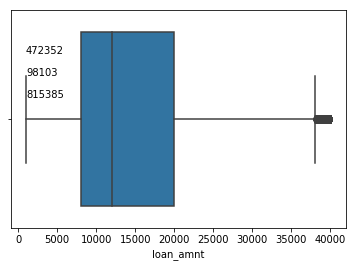

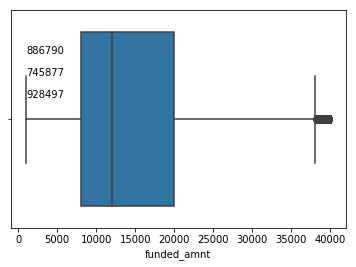

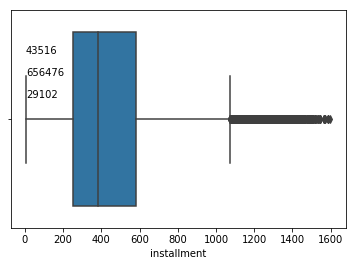

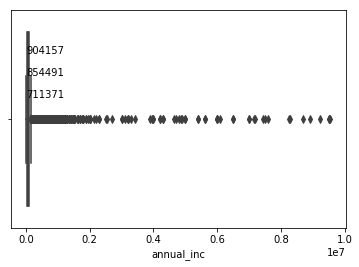

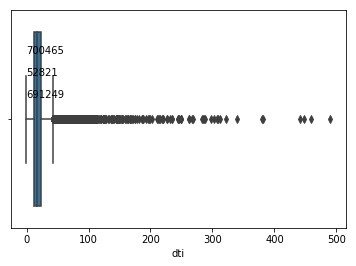

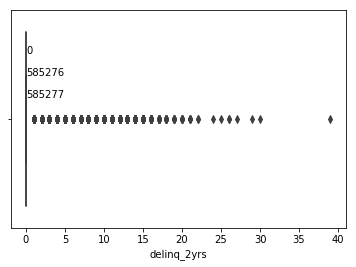

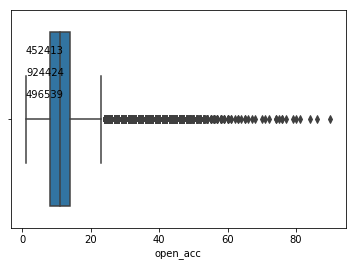

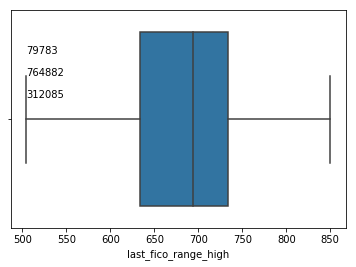

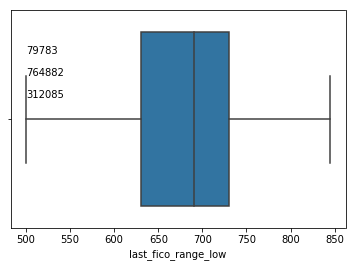

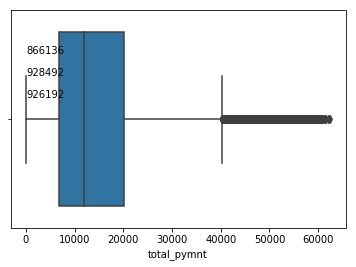

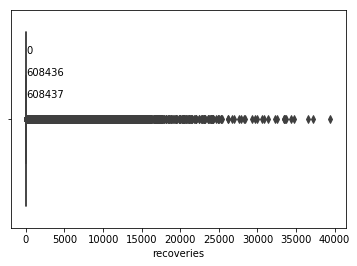

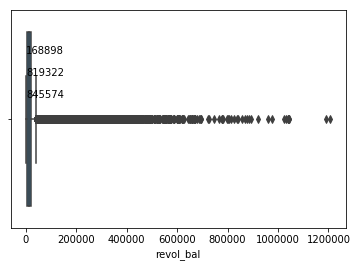

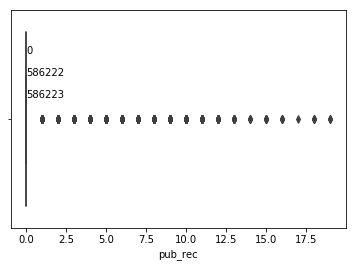

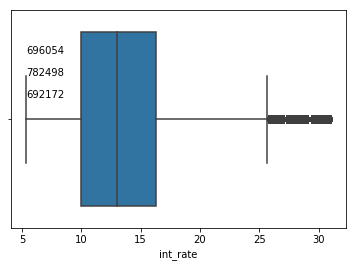

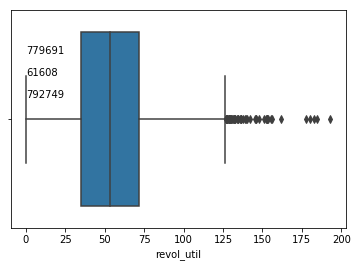

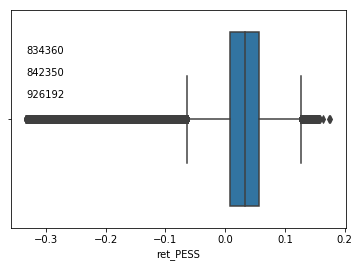

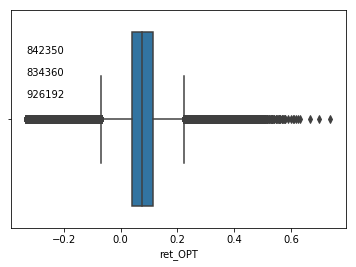

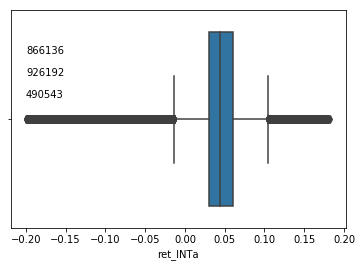

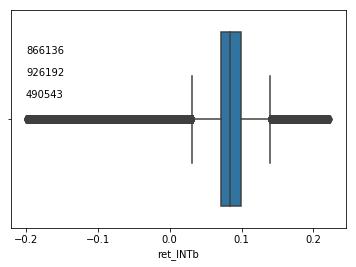

term
2
[[' 36 months' '702581']
 [' 60 months' '228910']]


grade
7
[['A' '154241']
 ['B' '268906']
 ['C' '262130']
 ['D' '143781']
 ['E' '70508']
 ['F' '25108']
 ['G' '6817']]


emp_length
12
[['1 year' '60628']
 ['10+ years' '306040']
 ['2 years' '84011']
 ['3 years' '74082']
 ['4 years' '55495']
 ['5 years' '58910']
 ['6 years' '45123']
 ['7 years' '43674']
 ['8 years' '43797']
 ['9 years' '36122']
 ['< 1 year' '73665']]


home_ownership
6
[['ANY' '129']
 ['MORTGAGE' '467137']
 ['NONE' '43']
 ['OTHER' '49']
 ['OWN' '96103']
 ['RENT' '368030']]


verification_status
3
[['Not Verified' '283729']
 ['Source Verified' '343372']
 ['Verified' '304390']]


loan_status
8
[['Charged Off' '168430']
 ['Default' '348']
 ['Does not meet the credit policy. Status:Charged Off' '241']
 ['Does not meet the credit policy. Status:Fully Paid' '725']
 ['Fully Paid' '727966']
 ['In Grace Period' '8703']
 ['Late (16-30 days)' '5707']
 ['Late (31-120 days)' '19371']]


purpose
14
[['car' '9788']
 ['credit_c

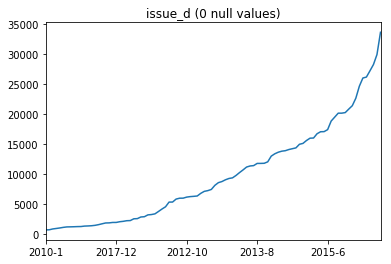

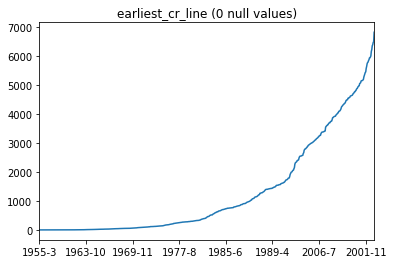

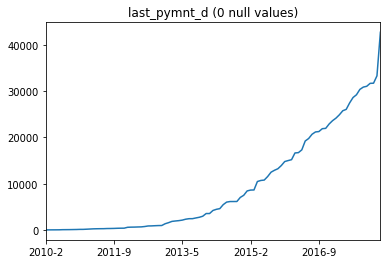

In [12]:
# Visualize the data again after cleaning
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

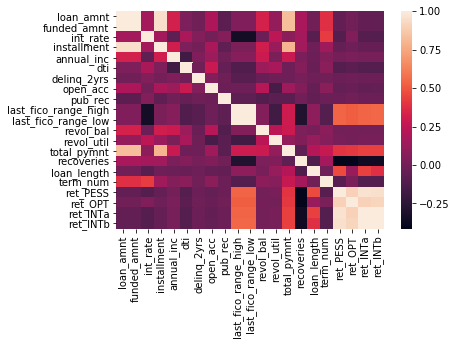

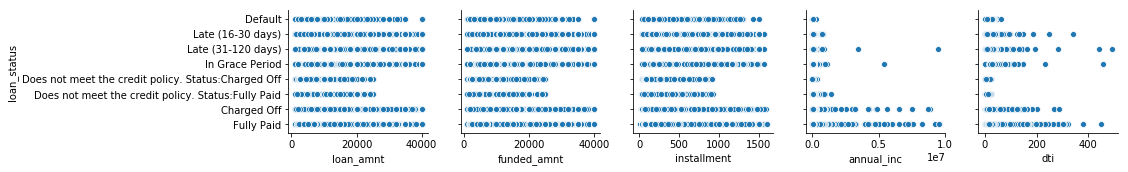

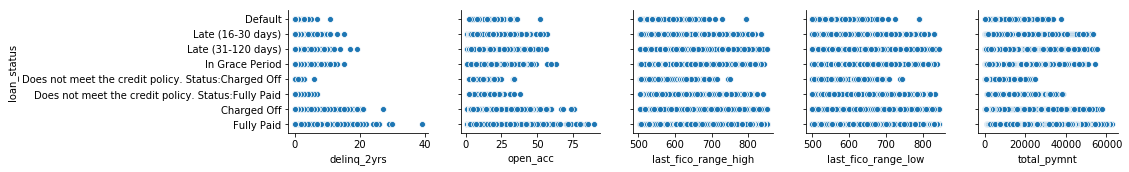

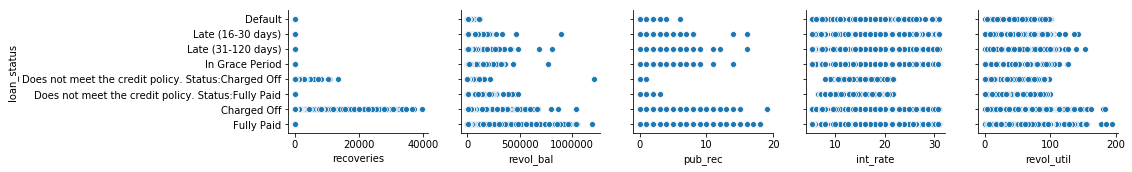

In [13]:
# Visualize the feature correlations
    # You can compute the correlation among features and display a heat-map of the matrix 
    # OR use sns scatter or pairplot
#sns.pairplot(final_data, vars = float_cols)
corr = final_data.corr()
sns.heatmap(corr);

# Visualize relation between loan status and features
# sns pairplot or scatter plot. Refer to recitations
sns.pairplot(final_data, y_vars = 'loan_status', x_vars = continuous_features[:5]) 
sns.pairplot(final_data, y_vars = 'loan_status', x_vars = continuous_features[5:10]) 
sns.pairplot(final_data, y_vars = 'loan_status', x_vars = continuous_features[10:15]) 

**What do you observe after removing the outliers?**

The amount of data decreases about 50%. from the correlation plot and heatmap we can see that some variables are highly correlated, such as loan amount and funded amount, annaul_income. Different ways to calculate return has high correlation with each other. 

As for loan status and other features, loan status that does not meet the credit policy would have much smaller loan amount and other features such as dti and pub_rec. Besides, Charged off loans would have more recoveries.

## Data Exploration

In [14]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()
default_by_grade = final_data.groupby("grade").apply(lambda x:(x.loan_status != "Fully Paid").sum()*100/len(x))
ret_by_grade_OPT = final_data.groupby("grade").apply(lambda x:x.ret_OPT.sum()/len(x)) # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby("grade").apply(lambda x:x.ret_PESS.sum()/len(x)) # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby("grade").apply(lambda x:x.ret_INTa.sum()/len(x)) # average return for M3 when i=0.002
ret_by_grade_INTb = final_data.groupby("grade").apply(lambda x:x.ret_INTb.sum()/len(x)) # average return for M3 when i=0.005
int_rate_by_grade = final_data.groupby("grade").apply(lambda x:x.int_rate.sum()/len(x)) # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,16.558507,7.095390,7.211156,0.036490,0.014440,0.030620,0.066764
B,28.868341,14.841618,10.835313,0.045341,0.011468,0.029552,0.065655
C,28.140905,24.282608,14.072147,0.046915,0.000083,0.022479,0.057796
D,15.435576,31.883211,17.575219,0.049868,-0.005790,0.018474,0.053045
E,7.569370,40.011063,20.811858,0.052844,-0.014764,0.011257,0.044666
F,2.695464,45.901705,24.582715,0.057804,-0.019858,0.006530,0.039199
G,0.731837,50.476749,27.276573,0.054625,-0.035267,-0.006331,0.025015


**Based on the output of previous cell, write down your answers to Q.7 from the handout.**

(i) What percentage of loans are in each grade?
 As shown in the table.
 
(ii) What is the default rate in each grade? How do you interpret those numbers?
As shown in the table. It means that loans with lower grades are more likely to default. The features grades and default rates are negatively correlated.

(iii) What is the average interest rate in each grade? How do you interpret those numbers?
As shown in the table. It means that loans with lower grades will have higher rate of return due to the risk premium. The features grades and interest rates are negatively correlated, while the default rates and interest rates are positively correlated.

(iv) What is the average percentage (annual) return per grade (as calculated using the three methods in part 6.)? (Assume two different yearly rates for M 3: (i = 0.002) and (i = 0.005))
As shown in the table.

(v) Do these numbers surprise you? If you had to invest in one grade only, which loans would you invest in?
Yes, the investors seem likely to lose money in nearly all scenarios for M1 method. I would choose A to invest in since A got the highest average returns in M1 and M3 measures.


## Save a Pickle

In [15]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features.remove('total_pymnt')
continuous_features.remove('recoveries')

# save the prepared data for modeling in next Phase.
pickle.dump([final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )

**Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?**

Because when we calculate the returns, we have already used total_pymt and recoveries in linear equations. There would exist perfect linearity if we do not exclude the two features.